## Resumo:

Faça aqui o resumo das suas analises, destacando os pontos principais do seu projeto

## Análise dos dados:

Inicie aqui o desenvolvimento do seu projeto, não esqueça de adicionar textos curtos e objetivos para que os avaliadores entendam sua linha de raciocínio e as conclusões que você está chegando crie uma narrativa convincente e coerênte aos dados analisados.

### Importando as bibliotecas

In [128]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

Configuração abaixo para tornar  os  graficos mais legiveis utilizando o tema  escuro:

In [129]:
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [130]:
### Dados

### Importanto os dados  
Os dados foram extraidos  da [Brasil IO](https://brasil.io/dataset/covid19/caso/), no dia 12-11-2020

In [131]:
dados_covid = pd.read_csv('https://www.dropbox.com/s/6vhga15llnr1wmo/caso_full.csv?dl=1')

### Exploração incial dos dados  
O objetivo de fazer uma exploração inicial na base de dados é identificar o comportamento do datast, falhas, necessidades  de conversão, tamanho das colunas e  outras informações necessárias ao desenvolvimento do projeto

In [132]:
#Amostra aleatoria do nosso data set
dados_covid.sample(10)

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
700735,Galvão,4205605.0,2020-09-12,37,2791.0,2873.0,False,False,15,537.44178,2020-09-12,0.0000,0,104,city,SC,0,0
93005,Barra do Ribeiro,4301909.0,2020-05-18,21,13556.0,13491.0,False,False,1,7.37681,2020-05-18,0.0000,0,6,city,RS,0,0
935800,Viçosa,2414902.0,2020-10-24,43,1725.0,1718.0,False,True,46,2666.66667,2020-10-23,0.0000,0,157,city,RN,0,0
461323,Coruripe,2702306.0,2020-08-01,31,57294.0,56933.0,False,False,1171,2043.84403,2020-08-01,0.0205,24,95,city,AL,11,0
648313,São Caetano de Odivelas,1507102.0,2020-09-03,36,18129.0,18050.0,False,False,512,2824.20431,2020-09-03,0.0332,17,135,city,PA,14,0
508325,Belém,1501402.0,2020-08-09,33,1499641.0,1492745.0,False,False,28095,1873.44838,2020-08-09,0.0733,2059,145,city,PA,88,1
266167,Uruana de Minas,3170479.0,2020-06-26,26,3260.0,3264.0,False,False,1,30.67485,2020-06-26,0.0000,0,2,city,MG,0,0
911642,Três Corações,3169307.0,2020-10-20,43,80032.0,79482.0,False,False,755,943.37265,2020-10-20,0.0411,31,176,city,MG,0,0
783821,Palotina,4117909.0,2020-09-27,40,32121.0,31846.0,False,False,868,2702.28200,2020-09-27,0.0161,14,150,city,PR,3,0
428102,Mazagão,1600402.0,2020-07-26,31,22053.0,21632.0,False,False,1002,4543.59951,2020-07-26,0.0070,7,104,city,AP,0,0


In [133]:
#formato do dataset, linhas x colunas
dados_covid.shape

(1038605, 18)

In [134]:
#Função para estatisticas basicas do nosso data set
dados_covid.describe()

,city_ibge_code,epidemiological_week,estimated_population,estimated_population_2019,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,order_for_place,new_confirmed,new_deaths
count,1.034478e+06,1.038605e+06,1.034478e+06,1.034478e+06,1.038605e+06,1.020387e+06,1.038605e+06,1.038605e+06,1.038605e+06,1.038605e+06,1.038605e+06
mean,3.202752e+06,3.250429e+01,9.616536e+04,9.542685e+04,1.070170e+03,1.092717e+03,3.500892e-02,3.490985e+01,9.547952e+01,1.085391e+01,3.110461e-01
std,1.013799e+06,8.190521e+00,1.012643e+06,1.005322e+06,1.332354e+04,1.384576e+03,9.026940e-02,5.042752e+02,5.727905e+01,1.448364e+02,4.656631e+00
min,1.100000e+01,9.000000e+00,7.760000e+02,7.810000e+02,0.000000e+00,2.160000e-03,0.000000e+00,0.000000e+00,1.000000e+00,-6.791000e+03,-1.870000e+02
25%,2.505006e+06,2.600000e+01,6.064000e+03,6.046000e+03,1.300000e+01,1.369706e+02,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00
50%,3.141405e+06,3.300000e+01,1.343500e+04,1.335300e+04,6.300000e+01,6.248008e+02,1.530000e-02,1.000000e+00,9.300000e+01,0.000000e+00,0.000000e+00
75%,4.113809e+06,3.900000e+01,2.986000e+04,2.968900e+04,2.690000e+02,1.538894e+03,3.480000e-02,6.000000e+00,1.400000e+02,2.000000e+00,0.000000e+00
max,5.300108e+06,4.600000e+01,4.628933e+07,4.591905e+07,1.150872e+06,2.237154e+04,1.000000e+00,3.990700e+04,2.610000e+02,3.091300e+04,4.550000e+02


In [135]:
#Util para saber os tipos dos dados em cada coluna
dados_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038605 entries, 0 to 1038604
Data columns (total 18 columns):
 #   Column                                         Non-Null Count    Dtype  
---  ------                                         --------------    -----  
 0   city                                           1032013 non-null  object 
 1   city_ibge_code                                 1034478 non-null  float64
 2   date                                           1038605 non-null  object 
 3   epidemiological_week                           1038605 non-null  int64  
 4   estimated_population                           1034478 non-null  float64
 5   estimated_population_2019                      1034478 non-null  float64
 6   is_last                                        1038605 non-null  bool   
 7   is_repeated                                    1038605 non-null  bool   
 8   last_available_confirmed                       1038605 non-null  int64  
 9   last_available_confirmed

É importante saber qual a porcentagem de dados validos(não nulos) da nossa base pois assim conseguimos garantir maior consistencia nos resultados. Caso tenha alguma coluna com um percentual baixo de dados validos, não irei considera-lo na analise.

In [136]:
round((dados_covid.notna().sum()/(dados_covid.notna().sum() + dados_covid.isna().sum()))*100,2)

city                                              99.37
city_ibge_code                                    99.60
date                                             100.00
epidemiological_week                             100.00
estimated_population                              99.60
estimated_population_2019                         99.60
is_last                                          100.00
is_repeated                                      100.00
last_available_confirmed                         100.00
last_available_confirmed_per_100k_inhabitants     98.25
last_available_date                              100.00
last_available_death_rate                        100.00
last_available_deaths                            100.00
order_for_place                                  100.00
place_type                                       100.00
state                                            100.00
new_confirmed                                    100.00
new_deaths                                      

### Limpeza do dataset

O próximo passo após exploração inicial é limpar e adequar o dataset de acordo com o nosso objetivo

In [137]:
#Converter os colunas com data para o tipo datetime
dados_covid['date'] = pd.to_datetime(dados_covid['date'], yearfirst=True)
dados_covid['last_available_date'] = pd.to_datetime(dados_covid['last_available_date'], yearfirst=True)

A [documentação](https://github.com/turicas/covid19-br/blob/master/api.md#casos) da nossa fonte de dados informa  que os valores da coluna _estimated_population_2019_ está desatualizada e orienta utilizar a coluna _estimated_population_ portanto podemos excluir ela do nosso dataset

In [138]:
dados_covid.drop('estimated_population_2019', axis=1, inplace=True)

Para nossa analise será necessário tambem sabermos a cidade do ocorrido, e temos algumas falhas nessas linhas(0,63%) então podemos elimina-las sem grande prejuizo.

In [139]:
dados_covid = dados_covid.query("city != 'Importados/Indefinidos'")
dados_covid = dados_covid[dados_covid['city'].isna() == False]

In [140]:
round((dados_covid.notna().sum()/(dados_covid.notna().sum() + dados_covid.isna().sum()))*100,2)

city                                             100.00
city_ibge_code                                   100.00
date                                             100.00
epidemiological_week                             100.00
estimated_population                             100.00
is_last                                          100.00
is_repeated                                      100.00
last_available_confirmed                         100.00
last_available_confirmed_per_100k_inhabitants     98.63
last_available_date                              100.00
last_available_death_rate                        100.00
last_available_deaths                            100.00
order_for_place                                  100.00
place_type                                       100.00
state                                            100.00
new_confirmed                                    100.00
new_deaths                                       100.00
dtype: float64

Ainda temos a coluna _last_available_confirmed_per_100k_inhabitants_ com algumas  falhas, como podemos facilmente calcular esse  valor com os dados que nos já temos, iremos excluir esta coluna e adicionar uma nova com o nosso calculo.

In [141]:
dados_covid.drop('last_available_confirmed_per_100k_inhabitants', axis=1, inplace=True)
dados_covid['last_available_confirmed_per_100k_inhabitants'] = dados_covid['last_available_confirmed'] * (dados_covid['estimated_population']/100000)

In [142]:
round((dados_covid.notna().sum()/(dados_covid.notna().sum() + dados_covid.isna().sum()))*100,2)

city                                             100.0
city_ibge_code                                   100.0
date                                             100.0
epidemiological_week                             100.0
estimated_population                             100.0
is_last                                          100.0
is_repeated                                      100.0
last_available_confirmed                         100.0
last_available_date                              100.0
last_available_death_rate                        100.0
last_available_deaths                            100.0
order_for_place                                  100.0
place_type                                       100.0
state                                            100.0
new_confirmed                                    100.0
new_deaths                                       100.0
last_available_confirmed_per_100k_inhabitants    100.0
dtype: float64

Agora a base está completa e podemos começar a plotar alguns gráficos exploratórios

### Primeiro Grafico Exploratorio

Foi amplamente divulgado o que o numero de mortes tem diminuido ao longo da  epidemia, então, podemos plotar um grafico com os valores de novas mortes por semana epidemiológica, caso seja verdade iremos observar um aumento nas semanas do meio e  uma redução nas  finais.

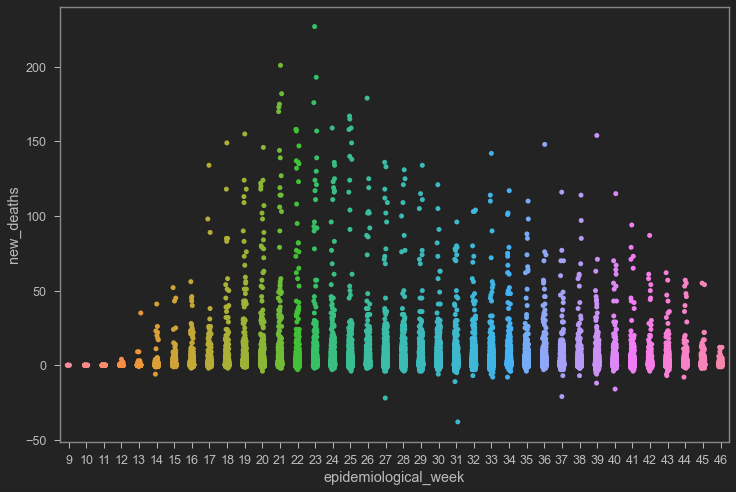

In [143]:
plt.figure( figsize=(12,8))
sns.stripplot(x='epidemiological_week',y='new_deaths',
               data=dados_covid[['epidemiological_week','new_deaths']])
plt.show()

Como os valores são por novas mortes, por dia e  por municipio, os valores são bem dispersos porem a  regra geral se mantem, é obseravel o comportamento de  redução à partir da semana  33. Porem algo chamou muita antenção, o numero de novas mortes negativas, como até hoje não há comprovação cientifica  de ressureição e tambem não foi noticiado nenhum inicio de apocalipse zumbi(não foi  dessa vez, #chateado), temos que descobrir o motivo desses numeros negativos, será uma falha no cadastro? Ou talvez possa ser uma correção nos numeros passados em dias anteriores?  
Mais uma vez, recorrendo a [documentação](https://github.com/turicas/covid19-br/blob/master/api.md#casos), podemos ver que os numeros negativos são de mortes  que foram remanejadas para outro municipio, estão registradas como negativo para que no somatorio total não se tenha um valor acima do real. Com base nessa informação podemos descartar esses dados da nossa base.

In [144]:
dados_covid = dados_covid.query("new_deaths >= 0")

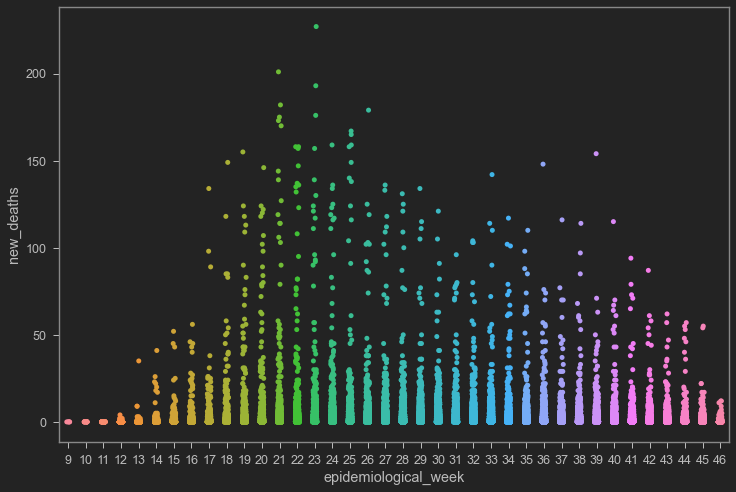

In [145]:
plt.figure( figsize=(12,8))
sns.stripplot(x='epidemiological_week',y='new_deaths',
               data=dados_covid[['epidemiological_week','new_deaths']])
plt.show()